In [ ]:
#Jory Hamilton
#02/03/2025
#AAI-530
#Assignment 4.1: LSTM Predictor Models

#Gemmini and the Module #4 Lab Session assisted with coding and overall for this assignment.

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [20]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [21]:
#use this cell to import additional libraries or define helper functions
from google.colab import drive #Importing library allowing Colab to interact with Google Drive
drive.mount('/content/drive') #Mounting Google Drive allows Colab to acces files from Drive
import matplotlib.pyplot as plt #For the graphical representations later in the lab
from sklearn.metrics import mean_squared_error as mse # Importing mean_squared_error and aliasing it as mse
!sudo apt-get update #Updates the package list on the system
!sudo apt-get install pandoc #Installs pandoc (doc converter)
!apt-get update #Updates package (ensuring that its up-to-date)
!apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-extra #Installs LaTex package#use this cell to import additional libraries or define helper functions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' 

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here
df = pd.read_csv("/content/drive/MyDrive/household_power_clean.csv") #Defining a path to the .csv file in MyDrive, reading it into a pandas df

In [ ]:
#create your training and validation sets here

#assign size for data subset
subset_size = int(len(df) * 0.01)

#take random data subset
#subset_df = df.sample(n=subset_size, random_state=1234)
#split data subset 80/20 for train/validation
#train_df, val_df = train_test_split(subset_df, test_size=0.2, random_state=1234)
#Changes made here are to prevent in the Global Active Power Prediction for the last 500 points

# Take a continuous slice for the subset
subset_df = df[:subset_size]

# Calculate the split index within the subset
split_index = int(len(subset_df) * 0.8)

# Split the subset into training and validation sets
train_df = subset_df[:split_index]
val_df = subset_df[split_index:]

In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [ ]:
seq_arrays = []
seq_labs = []

In [ ]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(0, len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols][i : i + seq_length].values)
    seq_labs.append(train_df['Global_active_power'][i + seq_length + ph -1]) #ph-1 for the horizon

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [ ]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [ ]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:
seq_arrays.shape verifies the shape and dimensions of the data structures from the module above the assertion (i.e., seq_arrays and seq_labs) to help catch and prevent errors/bugs.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [ ]:
#define path to save model
model_path = 'LSTM_model1.keras'

#build the network
nb_features = seq_arrays.shape[2]  # Number of features (1 in this case)
nb_out = 1  # Number of outputs (1 for regression)

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),  # Input shape (seq_length, nb_features)
         units=5,  # 5 hidden units
         return_sequences=True))  # Return sequences for next LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization

#add second LSTM layer
model.add(LSTM(
          units=3,  # 3 hidden units
          return_sequences=False))  # No need to return sequences for Dense layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(units=nb_out))  # Dense layer for output
model.add(Activation('linear'))  # Linear activation for regression

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

#fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

#list all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 5s - 145ms/step - loss: 2.9195 - mse: 2.9195 - val_loss: 0.2715 - val_mse: 0.2715
Epoch 2/100
32/32 - 0s - 11ms/step - loss: 1.2084 - mse: 1.2084 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 3/100
32/32 - 0s - 9ms/step - loss: 1.0146 - mse: 1.0146 - val_loss: 0.1134 - val_mse: 0.1134
Epoch 4/100
32/32 - 0s - 9ms/step - loss: 0.9135 - mse: 0.9135 - val_loss: 0.1056 - val_mse: 0.1056
Epoch 5/100
32/32 - 0s - 9ms/step - loss: 0.8518 - mse: 0.8518 - val_loss: 0.1068 - val_mse: 0.1068
Epoch 6/100
32/32 - 0s - 8ms/step - loss: 0.7846 - mse: 0.7846 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 7/100
32/32 - 0s - 9ms/step - loss: 0.7495 - mse: 0.7495 - val_loss: 0.0957 - val_mse: 0.0957
Epoch 8/100
32/32 - 0s - 8ms/step - loss: 0.7375 - mse: 0.7375 - val_loss: 0.0973 - val_mse: 0.0973
Epoch 9/100
32/32 - 0s - 8ms/step - loss: 0.7228 - mse: 0.7228 - val_loss: 0.0964 - val_mse: 0.0964
Epoch 10/100
32/32 - 0s - 8ms/step - loss: 0.7051 - mse: 0.7051 - val_loss: 0.1011 - val_mse

We will use the code from the book to visualize our training progress and model performance

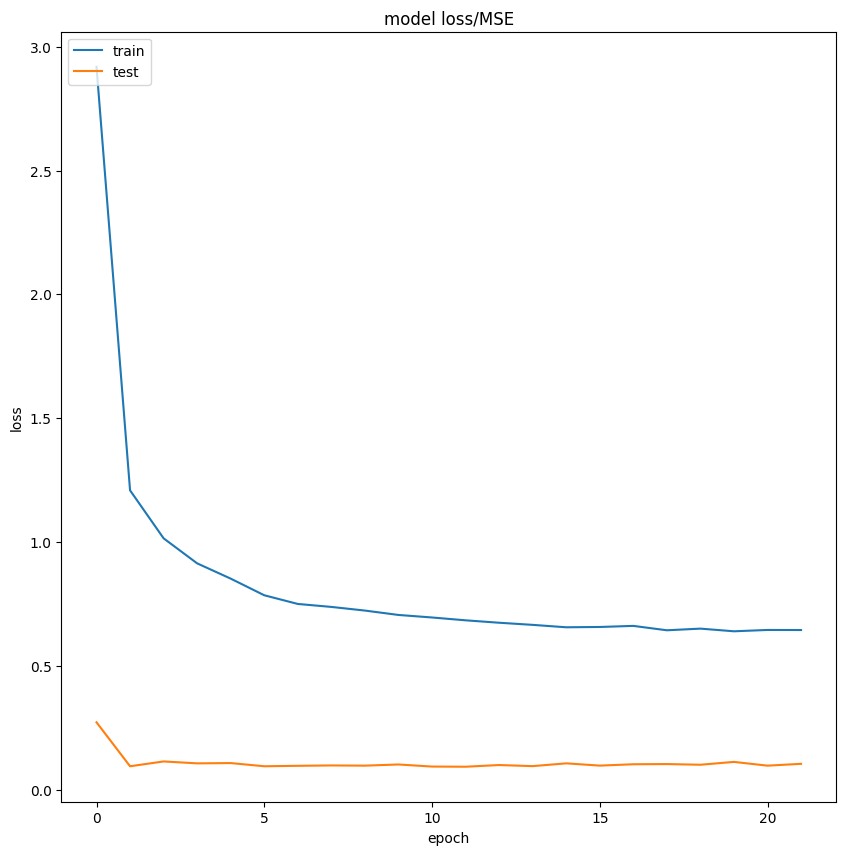

In [ ]:
#summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: pad_sequences (Keras) transforms sequences into a 2D NumPy array, padding (pre,  post) the argument by changing sequences into the same length. pre use the most recent data for predictions, which makes the most sense (predictions taking place only after GAP measurements taken).

In [ ]:
val_arrays = []
val_labs = []

# Create list of GAP readings starting with a minimum of two readings
for i in range(0, len(val_df) - seq_length - ph):
    if i < 2:  # Pad sequences shorter than seq_length
        temp_seq_arr = pad_sequences(
            [val_df[feat_cols][i : i + seq_length].values],
            maxlen=seq_length,
            dtype="float32",
            padding="pre",
            truncating="pre",
            value=0.0,
        )
        val_arrays.append(temp_seq_arr[0])  # Append padded sequence
    else:
        val_arrays.append(val_df[feat_cols][i : i + seq_length].values)
    val_labs.append(val_df['Global_active_power'][i + seq_length + ph - 1])

# Convert labels to NumPy arrays and floats to appease Keras/TensorFlow
val_arrays = np.array(val_arrays, dtype=object).astype(np.float32)
val_labs = np.array(val_labs, dtype=object).astype(np.float32)

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 0s - 3ms/step - loss: 0.6199 - mse: 0.6199

MSE: 0.619909405708313
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


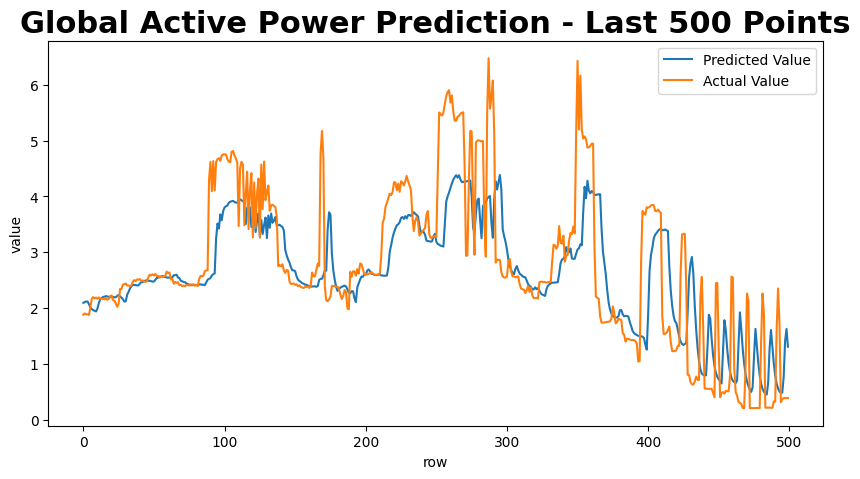

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The lower the MSE and a decreasing training and validation loss the better the model appears to be learning. MSE (0.6199) could be lower and the behavior of the actual and predict values increasing then ultimately decreasing, in waves, both show that while there was learning, there is room for improvement (e.g., feature engineering, hyperparameter tuning, more layers, normalizing input data).


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

In [ ]:
#play with your ideas for optimization here

#Define the additional features to include in the input sequence
additional_features = ['Global_reactive_power', 'Voltage', 'Global_intensity',
                       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

#Update feat_cols to include the additional features
feat_cols = ['Global_active_power'] + additional_features

#Create list of sequence length GAP readings
seq_arrays = []
seq_labs = []
for i in range(0, len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols][i : i + seq_length].values)
    seq_labs.append(train_df['Global_active_power'][i + seq_length + ph -1]) #ph-1 for the horizon

#Convert to NumPy arrays and floats to appease Keras/TensorFlow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)


#Build the network with more hidden layers
model = Sequential()

#Add first LSTM layer with more hidden units
model.add(LSTM(
         input_shape=(seq_length, len(feat_cols)),  # Input shape updated with additional features
         units=10,  # Increased number of hidden units
         return_sequences=True))
model.add(Dropout(0.2))

#Add second LSTM layer with more hidden units
model.add(LSTM(
          units=6,  # Increased number of hidden units
          return_sequences=False))
model.add(Dropout(0.2))

#Add a Dense layer for the output
model.add(Dense(units=nb_out))  # nb_out should be 1 for regression

#Add a linear activation function for regression
model.add(Activation('linear'))

#Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

#Fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

#List all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 10)              │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 6)                   │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,135 (4.43 KB)

 Trainable params: 1,135 (4.43 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 4s - 112ms/step - loss: 3.1154 - mse: 3.1154 - val_loss: 1.8412 - val_mse: 1.8412
Epoch 2/100
32/32 - 0s - 11ms/step - loss: 2.1349 - mse: 2.1349 - val_loss: 1.4437 - val_mse: 1.4437
Epoch 3/100
32/32 - 0s - 10ms/step - loss: 2.0813 - mse: 2.0813 - val_loss: 1.4985 - val_mse: 1.4985
Epoch 4/100
32/32 - 0s - 9ms/step - loss: 2.0569 - mse: 2.0569 - val_loss: 1.4979 - val_mse: 1.4979
Epoch 5/100
32/32 - 0s - 10ms/step - loss: 1.8383 - mse: 1.8383 - val_loss: 1.0068 - val_mse: 1.0068
Epoch 6/100
32/32 - 0s - 10ms/step - loss: 1.1905 - mse: 1.1905 - val_loss: 0.3083 - val_mse: 0.3083
Epoch 7/100
32/32 - 0s - 8ms/step - loss: 0.9920 - mse: 0.9920 - val_loss: 0.3345 - val_mse: 0.3345
Epoch 8/100
32/32 - 0s - 10ms/step - loss: 0.9493 - mse: 0.9493 - val_loss: 0.2651 - val_mse: 0.2651
Epoch 9/100
32/32 - 0s - 9ms/step - loss: 0.9150 - mse: 0.9150 - val_loss: 0.2063 - val_mse: 0.2063
Epoch 10/100
32/32 - 0s - 9ms/step - loss: 0.8709 - mse: 0.8709 - val_loss: 0.1966 - val

In [ ]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
val_arrays = []
val_labs = []

# Create list of GAP readings starting with a minimum of two readings
for i in range(0, len(val_df) - seq_length - ph):
    if i < 2:  # Pad sequences shorter than seq_length
        temp_seq_arr = pad_sequences(
            [val_df[feat_cols][i : i + seq_length].values],
            maxlen=seq_length,
            dtype="float32",
            padding="pre",
            truncating="pre",
            value=0.0,
        )
        val_arrays.append(temp_seq_arr[0])  # Append padded sequence
    else:
        val_arrays.append(val_df[feat_cols][i : i + seq_length].values)
    val_labs.append(val_df['Global_active_power'][i + seq_length + ph - 1])

# Convert labels to NumPy arrays and floats to appease Keras/TensorFlow
val_arrays = np.array(val_arrays, dtype=object).astype(np.float32)
val_labs = np.array(val_labs, dtype=object).astype(np.float32)

127/127 - 0s - 3ms/step - loss: 0.8266 - mse: 0.8266

MSE: 0.8265877962112427
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


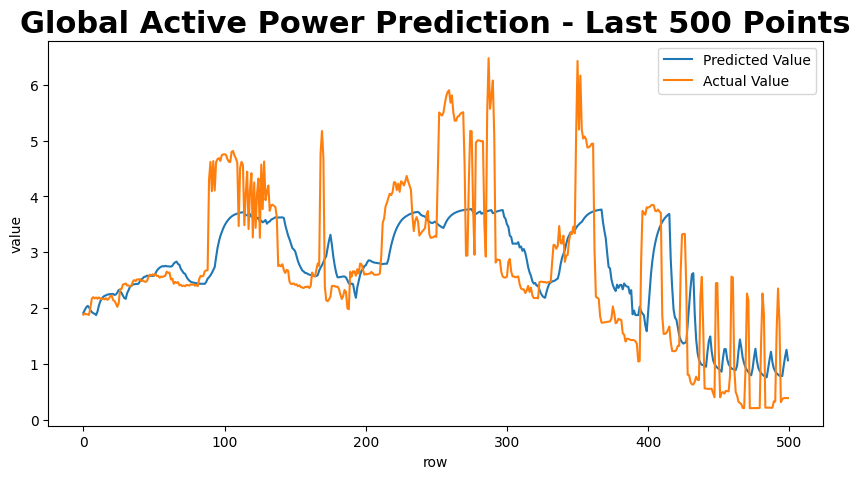

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: Adding varabiles and hidden layers increased the complexity of the model, which can capture more from the training data. However, given the increased MSE and difference between actual and predicted values, overfitting took place, where the model memorized the training data but further struggled to generalize to new data.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Some of the linear regression model MSE were about 0.59 last week for me. That is comparable to the original model this week (before improvements were made). However, given that I did not troubleshoot errors related to the last points (showing verticle lines), my MSE was likely way off (e.g., around an MSE of 7), with this week outperforming last week by far (given that error). Other students (e.g., Aryaz) were able to resolve the issue. But given that I wasn't, I can't make the most accurate assessment while comparing the two (e.g., one model's readings versus an error).

In [22]:
!jupyter nbconvert --to pdf '/content/drive/My Drive/Hamilton_AAI530_LSTM_Regression_Assignment.ipynb'

[NbConvertApp] Converting notebook /content/drive/My Drive/Hamilton_AAI530_LSTM_Regression_Assignment.ipynb to pdf
[NbConvertApp] Support files will be in Hamilton_AAI530_LSTM_Regression_Assignment_files/
[NbConvertApp] Making directory ./Hamilton_AAI530_LSTM_Regression_Assignment_files
[NbConvertApp] Writing 120917 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 289151 bytes to /content/drive/My Drive/Hamilton_AAI530_LSTM_Regression_Assignment.pdf
